In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import os

load_dotenv()

True

In [ ]:
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Next-80B-A3B-Instruct",
    task="text-generation",
    huggingfacehub_api_token=os.getenv("HUGGINGFACEHUB_API_TOKEN")
)

model = ChatHuggingFace(llm=llm)

In [60]:
class SentimentSchema(BaseModel):
    
    sentiment: Literal["postive", "negative"] = Field(description="Sentiment of the review")


In [61]:
class DiagnosisSchema(BaseModel):
    
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="The category of issue mentioned in the review")
    tone: Literal["amgry", "frustated", "disappointed", "calm"] = Field(description=" The emotions tone expressed by the user")
    urgency: Literal["low", "medium", "high"] = Field(description="How urgent or critical the issue appears to be")


In [62]:
# Convert to JSON schema (Pydantic v2)
schema = SentimentSchema.model_json_schema()
structured_model = model.with_structured_output(schema)

In [63]:
# Convert to JSON schema (Pydantic v2)
schema_2 = DiagnosisSchema.model_json_schema()
structured_model_2 = model.with_structured_output(schema_2)

In [64]:
prompt = ("What is the sentiment of the following review: The software of Apple is bad")

In [65]:
structured_model.invoke(prompt)

{'sentiment': 'negative'}

In [66]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [ ]:
def find_sentiment(state: ReviewState):
    prompt = f"For the folowing review find out the sentiment \n{state['review']}"
    sentiment = structured_model.invoke(prompt)
    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:
    if state['sentiment'] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"

def positive_response(state: ReviewState):
    prompt = f"""
    Write a warm thank you message in response to the review: \n
    {state['review']} \n
    Also, kindly ask the user to leave feedback on our website.
    """
    response = model.invoke(prompt).content
    return {'response': response}

def run_diagnosis(state: ReviewState):
    prompt = f"""
    Diagnosis the negative review: \n\n
    '{state['review']}' \n\n
    Return issue_type, tone, and urgency
    """
    response = structured_model_2.invoke(prompt)
    return {'diagnosis': response}

def neagtive_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""
    You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """
    response = model.invoke(prompt).content
    return {'response': response}
    

In [94]:
graph = StateGraph(ReviewState)

# node
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('neagtive_response', neagtive_response)

# edge 
graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'neagtive_response')
graph.add_edge('neagtive_response', END)

# compile
workflow = graph.compile()

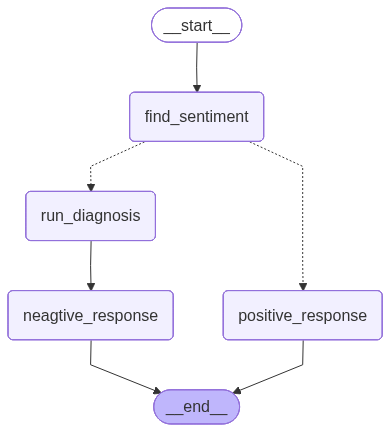

In [95]:
workflow

In [96]:
# executation
initial_state = {
    "review": "The product is very good"
}

workflow.invoke(initial_state)

{'review': 'The product is very good',
 'sentiment': {'sentiment': 'postive'},
 'diagnosis': {'issue_type': 'Other', 'tone': 'calm', 'urgency': 'low'},
 'response': 'Thank you for reaching out—and thank you for taking the time to share your concern, even though it may feel like a small matter. I truly appreciate your calm and thoughtful approach.\n\nI’m here to help, no matter how big or small the issue may seem. Please feel free to share more details about what you’re experiencing, and I’ll do my best to guide you through it step by step. Your satisfaction matters to us, and I’m committed to making this right for you—at your pace and on your terms.\n\nLooking forward to your next message. You’re not alone in this. 💙'}